In [12]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
        print("Setting GPU Memory Growth...")
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

import time
import datetime

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from plot_keras_history import plot_history
import sklearn.metrics as metrics
import os as os

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.python.client import device_lib

import kerastuner as kt
from kerastuner.tuners import RandomSearch, BayesianOptimization


print("TF version:", tf.__version__)
print("KT version:", kt.__version__)
print("Panda version:", pd.__version__)

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print("Physical devices: ", tf.config.list_physical_devices())
# Se va a habilitar la dedicacion dinamica de memoria para que la GPU vaya asignando recursos al proceso conforme los vaya necesitando

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
#print(tf.config.list_physical_devices('GPU'))
print("Build with CUDA: ", tf.test.is_built_with_cuda())

# Number of measurements to predict
numPredictions = 20

# Number of best models
numBestModels = 1 

# Validation set percentage
val_size = 0.3

# Batch size
batch = 1024

# Nodos internos
hidden_nodes = 10

# Units parameters
minUnits = 10
maxUnits = 50
stepsUnits = 10
defaultUnits = 30

# Layers parameters
minLayers = 1
maxLayers = 10
defaultLayers = 3

# Dropout Parameters
minDropout = 0
maxDropout = 0.33
defaultDropout = .25

# Establecer medida de loss
loss = "mean_absolute_error"

# Learning rate
learningRate = [0.0, 1e-2, 1e-3, 1e-4]

# Model metrics
modelMetrics = [keras.metrics.MAE, tf.keras.metrics.RootMeanSquaredError(name = 'rmse')]

# Optimizer objetive: error percetange with the validation set 
objective = kt.Objective('val_mean_absolute_error', 'min')

# Maximum model trials and executions
trials = 2
executions = 5

# Epochs
epchs = 1000

Setting GPU Memory Growth...


c:\Users\hecto\.conda\envs\myenv\lib\site-packages\tensorflow_core\python\client\session.py:1752: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


TF version: 2.1.0
KT version: 1.0.1
Panda version: 1.1.5
Physical devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Default GPU Device: /device:GPU:0
Num GPUs Available:  1
Build with CUDA:  True


In [13]:
df = pd.read_csv("C:/Users/hecto/Documents/Master/TFM/tfm-renewable-energy-deep-learning/data/training/2015_PV_W140_H20.csv",
                delimiter=";")

dfTest = pd.read_csv("C:/Users/hecto/Documents/Master/TFM/tfm-renewable-energy-deep-learning/data/test/2016_PV_W140_H20.csv",
                delimiter=";")

# X = pd.read_csv("C:/Users/hecto/Documents/Master/TFM/tfm-renewable-energy-deep-learning/data/training/2015_Weather_W1.csv",
#                        delimiter=",")

# xTest = pd.read_csv("C:/Users/hecto/Documents/Master/TFM/tfm-renewable-energy-deep-learning/data/test/2016_Weather_W1.csv",
#                    delimiter=",")

# projectNameBO = "Weather_W1-lstm-bo"
# projectNameRS = "Weather_W1-lstm-rs"

projectNameRS = "PV_W140_H20-lstm-rs"
projectNameBO = "PV_W140_H20-lstm-bo"

W=140
H=20

#  Uncomment in order to normalize data
# Data Normalization

df = df.replace(',', '.', regex=True)
dfTest = dfTest.replace(',', '.', regex=True)

scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df))
dfTest = pd.DataFrame(scaler.fit_transform(dfTest))

In [14]:
# # Preprocessing for W type files:

# # Filter for PV data
# X = X.iloc[:, ::PV_index]
# xTest = xTest.iloc[:, ::PV_index]

# numPredictions = len(X.columns)

# # Reset column names
# new_column_names = [f'PV_{i+1}' for i in range(numPredictions)]
# X.columns = new_column_names
# xTest.columns = new_column_names

# Y = pd.DataFrame.copy(X)
# yTest = pd.DataFrame.copy(xTest)

# # Create Y from taking next day data
# Y = Y.drop(0)
# Y = Y.reset_index(drop = True)
# Y.loc[len(Y)] = np.zeros(numPredictions)

# yTest = yTest.drop(0)
# yTest = yTest.reset_index(drop = True)
# yTest.loc[len(yTest)] = np.zeros(numPredictions)

# print(X)
# print(yTest)

In [15]:
# Preprocessing for PV_W_H type files:

# Filter for PV data
X = df.iloc[:, 0:W]
xTest = dfTest.iloc[:, 0:W]

Y = df.iloc[:, W:]
yTest = dfTest.iloc[:, W:]

numPredictions = H

print(X)
print(yTest)

          0         1         2         3         4         5         6    \
0    0.202547  0.343202  1.000000  0.842291  0.577134  0.745918  0.996233   
1    0.426514  0.294835  0.574558  0.485647  0.827078  0.838485  0.959061   
2    0.230347  0.267902  0.116575  0.189409  0.229192  0.324692  0.254022   
3    0.815427  0.732371  0.665736  0.544064  0.661029  0.580754  0.651991   
4    0.586870  0.752408  0.486835  0.536889  0.585460  0.500163  0.220289   
..        ...       ...       ...       ...       ...       ...       ...   
353  0.814352  0.884869  0.639417  0.734076  0.927453  0.945354  0.827834   
354  0.751755  0.893851  0.866711  0.999158  0.927207  0.927505  0.958282   
355  0.507537  0.664454  0.640321  0.697187  0.894575  0.850608  0.559587   
356  0.689605  0.568433  0.651532  0.811900  0.694811  0.655561  0.903678   
357  0.512738  0.738997  0.641405  0.495840  0.508740  0.454383  0.320331   

          7         8         9    ...       130       131       132  \
0  

In [16]:
# # Data preprocessing
# Y = pd.DataFrame.copy(X)
# yTest = pd.DataFrame.copy(xTest)

# numPredictions = len(X.columns)

# Y.columns = ["col_{}".format(i) for i in range(1, numPredictions + 1)]
# Y = Y.drop(0)
# Y = Y.reset_index(drop = True)
# Y.loc[len(Y)] = np.zeros(numPredictions)

# # Last row is deleted because it is the one used for the real prediction, 
# # it is not useful for the training of the model. 
# X.drop(X.tail(1).index, inplace = True)
# Y.drop(Y.tail(1).index, inplace = True)

# print("X Preproccessed shape: ", X.shape)
# print("Y Preproccessed shape: ", Y.shape)
# print("---------------------------------------------")

In [17]:
dfPreproccessed = pd.concat([X, Y], axis = 1)

print("DataFrame Preproccessed:")
print(dfPreproccessed)
print("---------------------------------------------")

# Split the data into training and validation sets
xTrain, xVal, yTrain, yVal = train_test_split(X, 
                                            Y, 
                                            test_size = val_size, 
                                            random_state = 0, 
                                            shuffle=False)

# Adding the third dimension needed to use LSTM (samples, timestamps, features)
xtrain = np.reshape(xTrain.values, (xTrain.shape[0], 1, xTrain.shape[1]))
ytrain = np.reshape(yTrain.values, (yTrain.shape[0], 1, yTrain.shape[1]))
xval = np.reshape(xVal.values, (xVal.shape[0], 1,  xVal.shape[1]))
yval = np.reshape(yVal.values, (yVal.shape[0], 1, yVal.shape[1]))
xtest = np.reshape(xTest.values, (xTest.shape[0], 1, xTest.shape[1]))
ytest = np.reshape(yTest.values, (yTest.shape[0], 1, yTest.shape[1]))

# New shapes after third dimension added
print("Dimensions afther third dimension added:")
print("xTrain:\t"+str(xtrain.shape))
print("yTrain:\t"+str(ytrain.shape))
print("xVal:\t"+str(xval.shape))
print("yVal:\t"+str(yval.shape))
print("xTest:\t"+str(xtest.shape))
print("yTest:\t"+str(ytest.shape))

DataFrame Preproccessed:
          0         1         2         3         4         5         6    \
0    0.202547  0.343202  1.000000  0.842291  0.577134  0.745918  0.996233   
1    0.426514  0.294835  0.574558  0.485647  0.827078  0.838485  0.959061   
2    0.230347  0.267902  0.116575  0.189409  0.229192  0.324692  0.254022   
3    0.815427  0.732371  0.665736  0.544064  0.661029  0.580754  0.651991   
4    0.586870  0.752408  0.486835  0.536889  0.585460  0.500163  0.220289   
..        ...       ...       ...       ...       ...       ...       ...   
353  0.814352  0.884869  0.639417  0.734076  0.927453  0.945354  0.827834   
354  0.751755  0.893851  0.866711  0.999158  0.927207  0.927505  0.958282   
355  0.507537  0.664454  0.640321  0.697187  0.894575  0.850608  0.559587   
356  0.689605  0.568433  0.651532  0.811900  0.694811  0.655561  0.903678   
357  0.512738  0.738997  0.641405  0.495840  0.508740  0.454383  0.320331   

          7         8         9    ...       150  

In [18]:
# Model definition:
with tf.device('/gpu:0'): 
    
    def build_model(hp): 

        model = Sequential()
        
        # model.add(LSTM(hidden_nodes, input_shape=(xtrain.shape[1], 1)))
        # First layer: LSTM. Number of units optimization
        model.add(LSTM(units = hp.Int('units', 
                                    min_value = minUnits,
                                    max_value = maxUnits, 
                                    step = stepsUnits,
                                    default = defaultUnits),
                        return_sequences = True, 
                        input_shape = (xtrain.shape[1], xtrain.shape[2])))

        # Second layer: Dropout with percetange optimization
        model.add(
            Dropout(hp.Float('dropout', 
                            min_value = minDropout,
                            max_value = maxDropout,
                            default = defaultDropout)))
        
        # Last layer:
        model.add(Dense(numPredictions))

        print("Summary: ")
        model.summary()

        # Model compilation: learning rate optimization
        model.compile(loss = loss,
                    optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', 
                                                                values = learningRate)),
                    metrics = modelMetrics)

        return model

In [19]:
# Model training:
with tf.device('/gpu:0'): 
    # Create optimizer using Random Search
    lstmOptimizer = RandomSearch(build_model, 
                                objective = objective,
                                max_trials = trials, 
                                executions_per_trial = executions,
                                project_name = projectNameRS,
                                overwrite=True)

    # Search space summary
    lstmOptimizer.search_space_summary()

    # Search execution with epochs
    initialTime = time.time()
    lstmOptimizer.search(x = xtrain,
                        y = ytrain, 
                        epochs = epchs,
                        batch_size = batch,
                        validation_data = (xval, yval))
    finalTime = time.time()

    # Results summary
    lstmOptimizer.results_summary()

    # Get best model generated
    model = lstmOptimizer.get_best_models(num_models = numBestModels)[0]

    # Model training with epochs 
    history = model.fit(
                xtrain,
                ytrain,
                epochs = epchs,
                batch_size = batch,
                validation_data = (xval, yval))

    # Show model info
    print("Tiempo de entrenamiento (en segundos):\t"+str(finalTime - initialTime))
    # print("Tiempo de entrenamiento (en horas):\t"+str((finalTime - initialTime)/3600))
    print(history.history.keys())
    print(model.history.history)
    print(model.history.params)

Summary: 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 30)             20520     
_________________________________________________________________
dropout (Dropout)            (None, 1, 30)             0         
_________________________________________________________________
dense (Dense)                (None, 1, 20)             620       
Total params: 21,140
Trainable params: 21,140
Non-trainable params: 0
_________________________________________________________________


Summary: 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 10)             6040      
_________________________________________________________________
dropout (Dropout)            (None, 1, 10)             0         
_________________________________________________________________
dense (Dense)                (None, 1, 20)             220       
Total params: 6,260
Trainable params: 6,260
Non-trainable params: 0
_________________________________________________________________
Train on 250 samples, validate on 108 samples
Epoch 1/1000
250/250 [==============================] - 1s 5ms/sample - loss: 0.4639 - mean_absolute_error: 0.4639 - rmse: 0.5300 - val_loss: 0.6301 - val_mean_absolute_error: 0.6301 - val_rmse: 0.6853
Epoch 2/1000
250/250 [==============================] - 0s 80us/sample - loss: 0.4657 - mean_absolute_error: 0.4657 - rmse: 0.

Summary: 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 30)             20520     
_________________________________________________________________
dropout (Dropout)            (None, 1, 30)             0         
_________________________________________________________________
dense (Dense)                (None, 1, 20)             620       
Total params: 21,140
Trainable params: 21,140
Non-trainable params: 0
_________________________________________________________________
Train on 250 samples, validate on 108 samples
Epoch 1/1000
250/250 [==============================] - 1s 5ms/sample - loss: 0.4615 - mean_absolute_error: 0.4615 - rmse: 0.5262 - val_loss: 0.6133 - val_mean_absolute_error: 0.6133 - val_rmse: 0.6804
Epoch 2/1000
250/250 [==============================] - 0s 222us/sample - loss: 0.4589 - mean_absolute_error: 0.4589 - rmse:

INFO:tensorflow:Oracle triggered exit


Summary: 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 30)             20520     
_________________________________________________________________
dropout (Dropout)            (None, 1, 30)             0         
_________________________________________________________________
dense (Dense)                (None, 1, 20)             620       
Total params: 21,140
Trainable params: 21,140
Non-trainable params: 0
_________________________________________________________________
Train on 250 samples, validate on 108 samples
Epoch 1/1000
250/250 [==============================] - 1s 5ms/sample - loss: 0.1399 - mean_absolute_error: 0.1399 - rmse: 0.1824 - val_loss: 0.2148 - val_mean_absolute_error: 0.2148 - val_rmse: 0.2583
Epoch 2/1000
250/250 [==============================] - 0s 77us/sample - loss: 0.1383 - mean_absolute_error: 0.1383 - rmse: 

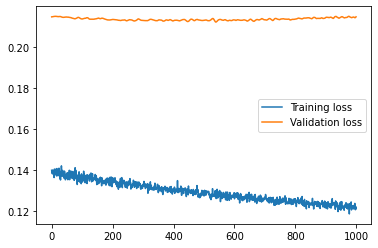

359/359 [==============================] - ETA: 0s - loss: 0.2326 - mean_absolute_error: 0.2326 - rmse: 0.28 - 0s 131us/sample - loss: 0.1599 - mean_absolute_error: 0.1599 - rmse: 0.2100
Score: [0.1598664380630743, 0.15986644, 0.21003655]


In [20]:
# Model evaluation:

# Training and Validation loss curves
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.legend()
plt.show()

# Model evaluation with validation data
score = model.evaluate(xtest, ytest)
print('Score:', score)

In [21]:
# Model training:
with tf.device('/gpu:0'): 
    # Create optimizer using Random Search
    lstmOptimizer = BayesianOptimization(build_model, 
                                objective = objective,
                                max_trials = trials, 
                                executions_per_trial = executions,
                                project_name = projectNameBO,
                                overwrite=True)

    # Search space summary
    lstmOptimizer.search_space_summary()

    # Search execution with epochs
    initialTime = time.time()
    lstmOptimizer.search(x = xtrain,
                        y = ytrain, 
                        epochs = epchs,
                        batch_size = batch,
                        validation_data = (xval, yval))
    finalTime = time.time()

    # Results summary
    lstmOptimizer.results_summary()

    # Get best model generated
    model = lstmOptimizer.get_best_models(num_models = numBestModels)[0]

    # Model training with epochs 
    history = model.fit(
                xtrain,
                ytrain,
                epochs = epchs,
                batch_size = batch,
                validation_data = (xval, yval))

    # Show model info
    print("Tiempo de entrenamiento (en segundos):\t"+str(finalTime - initialTime))
    # print("Tiempo de entrenamiento (en horas):\t"+str((finalTime - initialTime)/3600))
    print(history.history.keys())
    print(model.history.history)
    print(model.history.params)

Summary: 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 30)             20520     
_________________________________________________________________
dropout (Dropout)            (None, 1, 30)             0         
_________________________________________________________________
dense (Dense)                (None, 1, 20)             620       
Total params: 21,140
Trainable params: 21,140
Non-trainable params: 0
_________________________________________________________________


Summary: 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 40)             28960     
_________________________________________________________________
dropout (Dropout)            (None, 1, 40)             0         
_________________________________________________________________
dense (Dense)                (None, 1, 20)             820       
Total params: 29,780
Trainable params: 29,780
Non-trainable params: 0
_________________________________________________________________
Train on 250 samples, validate on 108 samples
Epoch 1/1000
250/250 [==============================] - 1s 4ms/sample - loss: 0.4745 - mean_absolute_error: 0.4745 - rmse: 0.5472 - val_loss: 0.4430 - val_mean_absolute_error: 0.4430 - val_rmse: 0.5475
Epoch 2/1000
250/250 [==============================] - 0s 191us/sample - loss: 0.3264 - mean_absolute_error: 0.3264 - rmse:

Summary: 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 40)             28960     
_________________________________________________________________
dropout (Dropout)            (None, 1, 40)             0         
_________________________________________________________________
dense (Dense)                (None, 1, 20)             820       
Total params: 29,780
Trainable params: 29,780
Non-trainable params: 0
_________________________________________________________________
Train on 250 samples, validate on 108 samples
Epoch 1/1000
250/250 [==============================] - 1s 5ms/sample - loss: 0.4664 - mean_absolute_error: 0.4664 - rmse: 0.5297 - val_loss: 0.6072 - val_mean_absolute_error: 0.6072 - val_rmse: 0.6629
Epoch 2/1000
250/250 [==============================] - 0s 211us/sample - loss: 0.4474 - mean_absolute_error: 0.4474 - rmse:

INFO:tensorflow:Oracle triggered exit


Summary: 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 40)             28960     
_________________________________________________________________
dropout (Dropout)            (None, 1, 40)             0         
_________________________________________________________________
dense (Dense)                (None, 1, 20)             820       
Total params: 29,780
Trainable params: 29,780
Non-trainable params: 0
_________________________________________________________________
Train on 250 samples, validate on 108 samples
Epoch 1/1000
250/250 [==============================] - 1s 5ms/sample - loss: 0.1278 - mean_absolute_error: 0.1278 - rmse: 0.1694 - val_loss: 0.2118 - val_mean_absolute_error: 0.2118 - val_rmse: 0.2608
Epoch 2/1000
250/250 [==============================] - 0s 68us/sample - loss: 0.1227 - mean_absolute_error: 0.1227 - rmse: 

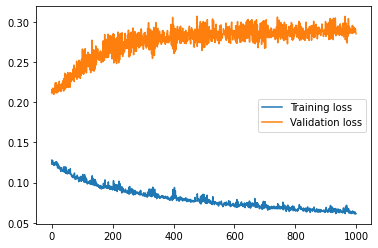

359/359 [==============================] - ETA: 0s - loss: 0.2975 - mean_absolute_error: 0.2975 - rmse: 0.36 - 0s 135us/sample - loss: 0.1995 - mean_absolute_error: 0.1995 - rmse: 0.2644
Score: [0.1994637699595401, 0.19946375, 0.2643737]


In [22]:
# Model evaluation:

# Training and Validation loss curves
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.legend()
plt.show()

# Model evaluation with validation data
score = model.evaluate(xtest, ytest)
print('Score:', score)